# Hastings Direct Takehome

Background:
Insurance companies make pricing decisions based on historical claims experience. The more recent the claims experience, the more predictive it may be of future losses. In the case of many large claims however, the exact cost is not known at the time of the accident. In fact, some cases take years to develop and settle. Companies sometimes learn that a claim is large several years after the accident took place.
Your Underwriting Director believes it is possible to predict the ultimate value of individual claims well in advance by using FNOL (First Notification Of Loss) characteristics. This is the information recorded when the claim is first notified. If so, it would allow the company to know about future costs earlier and this information could be used to make better pricing decisions.
You are given a historical dataset of a particular type of claim - head-on collisions - and are also told their individual current estimated values (labelled Incurred). (Given these claims are now a few years old, you can assume the incurred values are equal to the cost at which the claims will finally settle). 

Task breakdown:
1) Using this data, build a model to predict the ultimate individual claim amounts
"2) Prepare a 15 minute presentation summarising your model. Your presentation should either be in notebook format or a more traditional slide deck.  If you opt for the slide deck approach, please make sure that you provide supporting code. 
Your presentation should cover the following aspects:
- Issues identified with the data and how these were addressed
- Data cleansing
- Model specification and justification for selecting this model specification
- Assessment of your model's accuracy and model diagnostics
- Suggestions of how your model could be improved
- Practical challenges for implementing your model"

Note: columns beginning with TP_* show the number of third parties involved in an accident (under a given category)

# Data Cleaning


* After import I had to strip tab delimiters and currency characters

<div style="max-width:500px;margin-right: auto; margin-right: 0;">
    
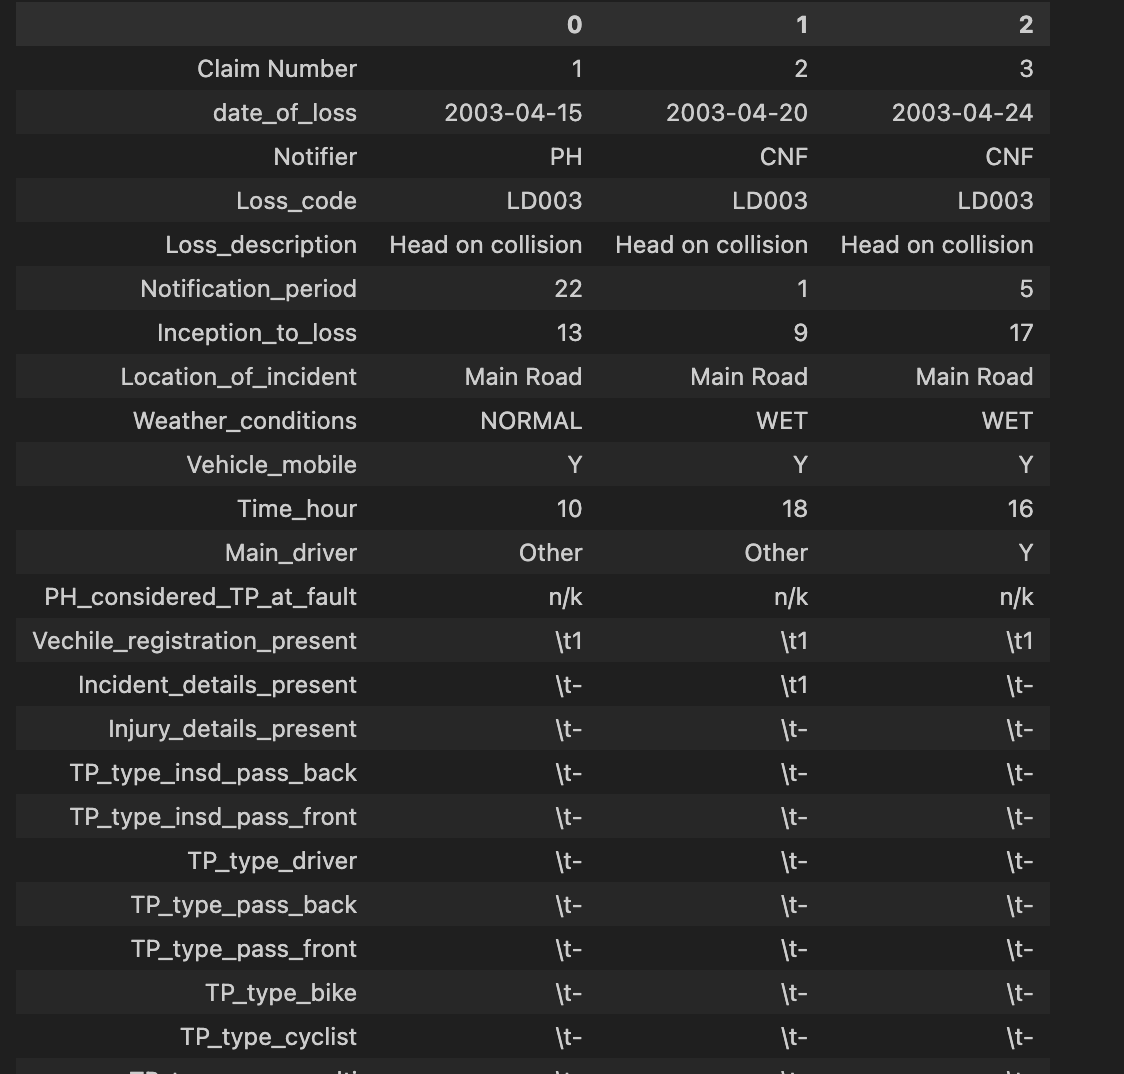
    
</div>






* I found some features constant so I dropped them

* Latest weather not reliable - did not fix but could have used external data joined on date. 

<div style="max-width:500px;margin-right: auto; margin-right: 0;">

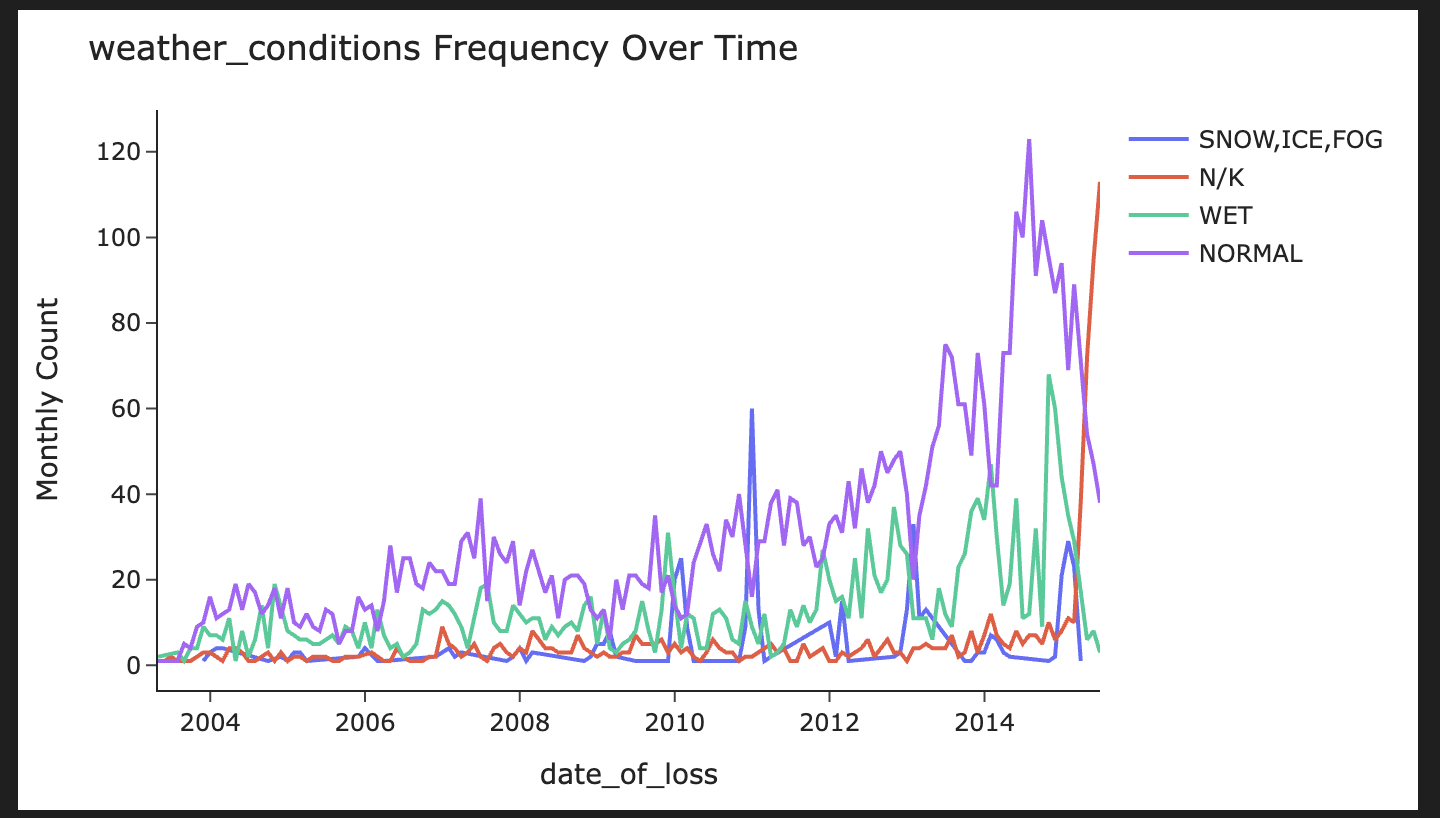

</div>

* Missing Targets I found they were consistently missing over time rather than clumped together

<div style="max-width:500px;margin-right: auto; margin-right: 0;">

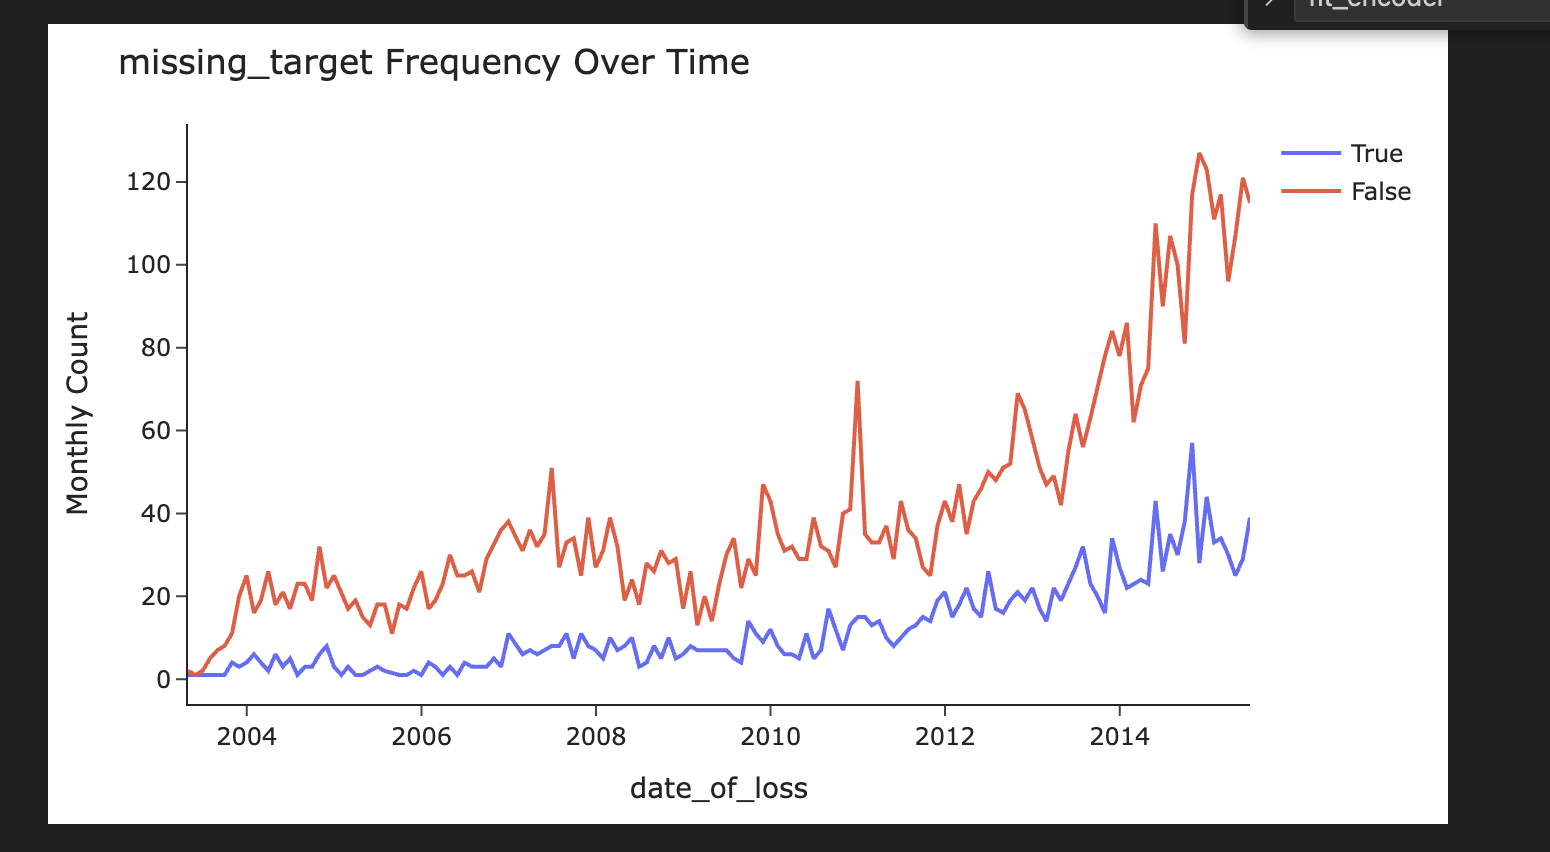

</div>

* I also added a vis to all my per column EDA to check if there was a noticeable relationship between missing target and predictors and didnt spot anything too worrying

<div style="max-width:500px;margin-right: auto; margin-right: 0;">

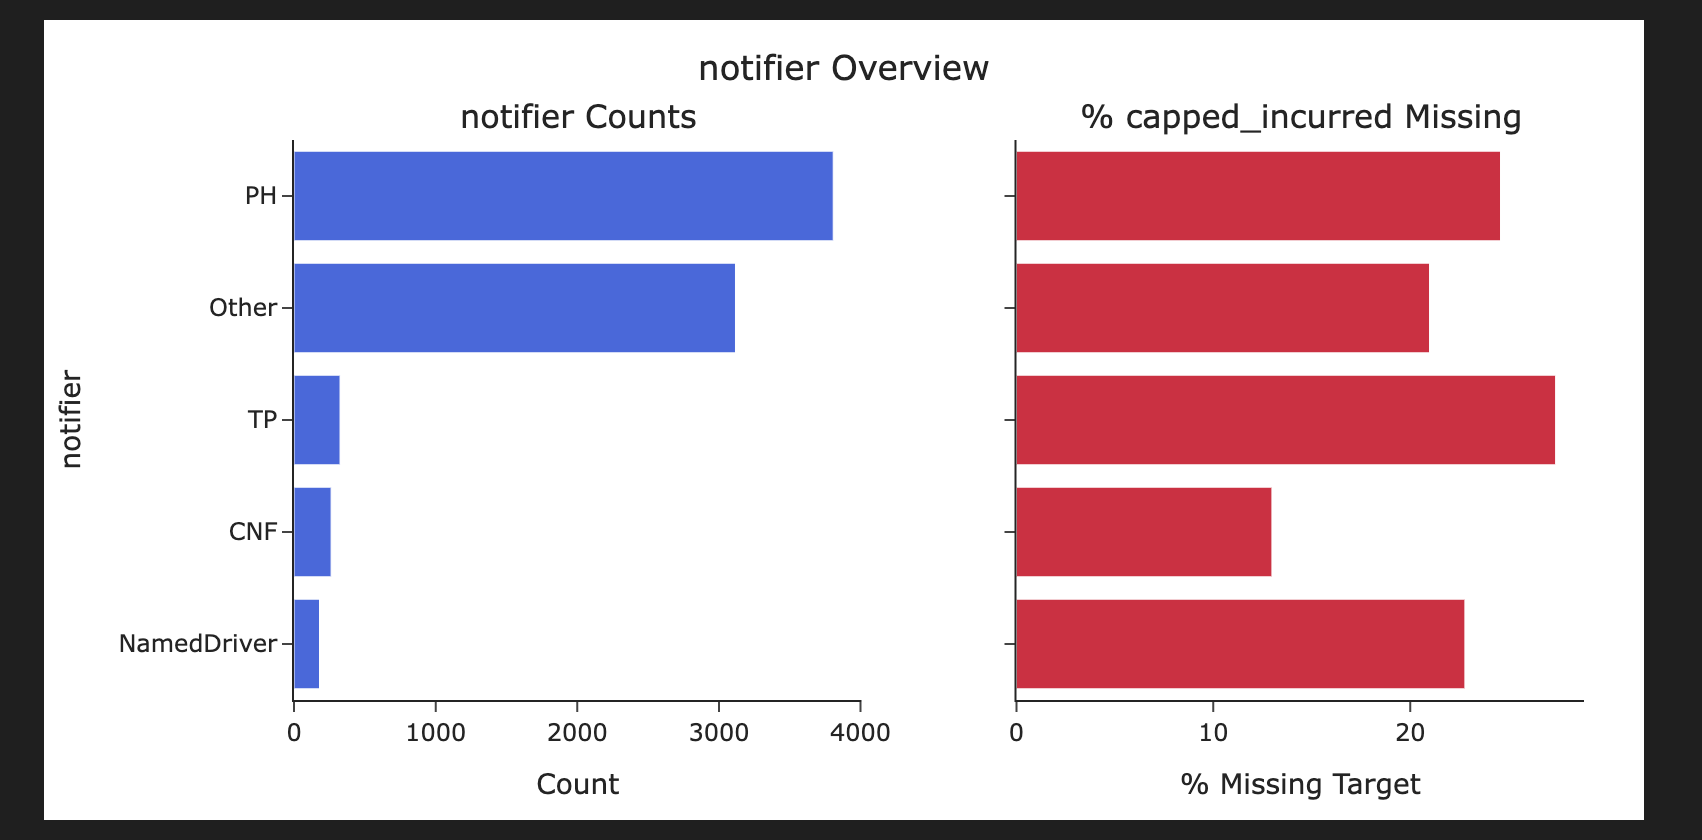

</div>

* Felt the sensible course was to drop these records from training set



* Outliers in targets - explored using logged features instead but ultimately found capped_incurred has best r2 without further transformations or different model spec.

<div style="max-width:500px;margin-right: auto; margin-right: 0;">

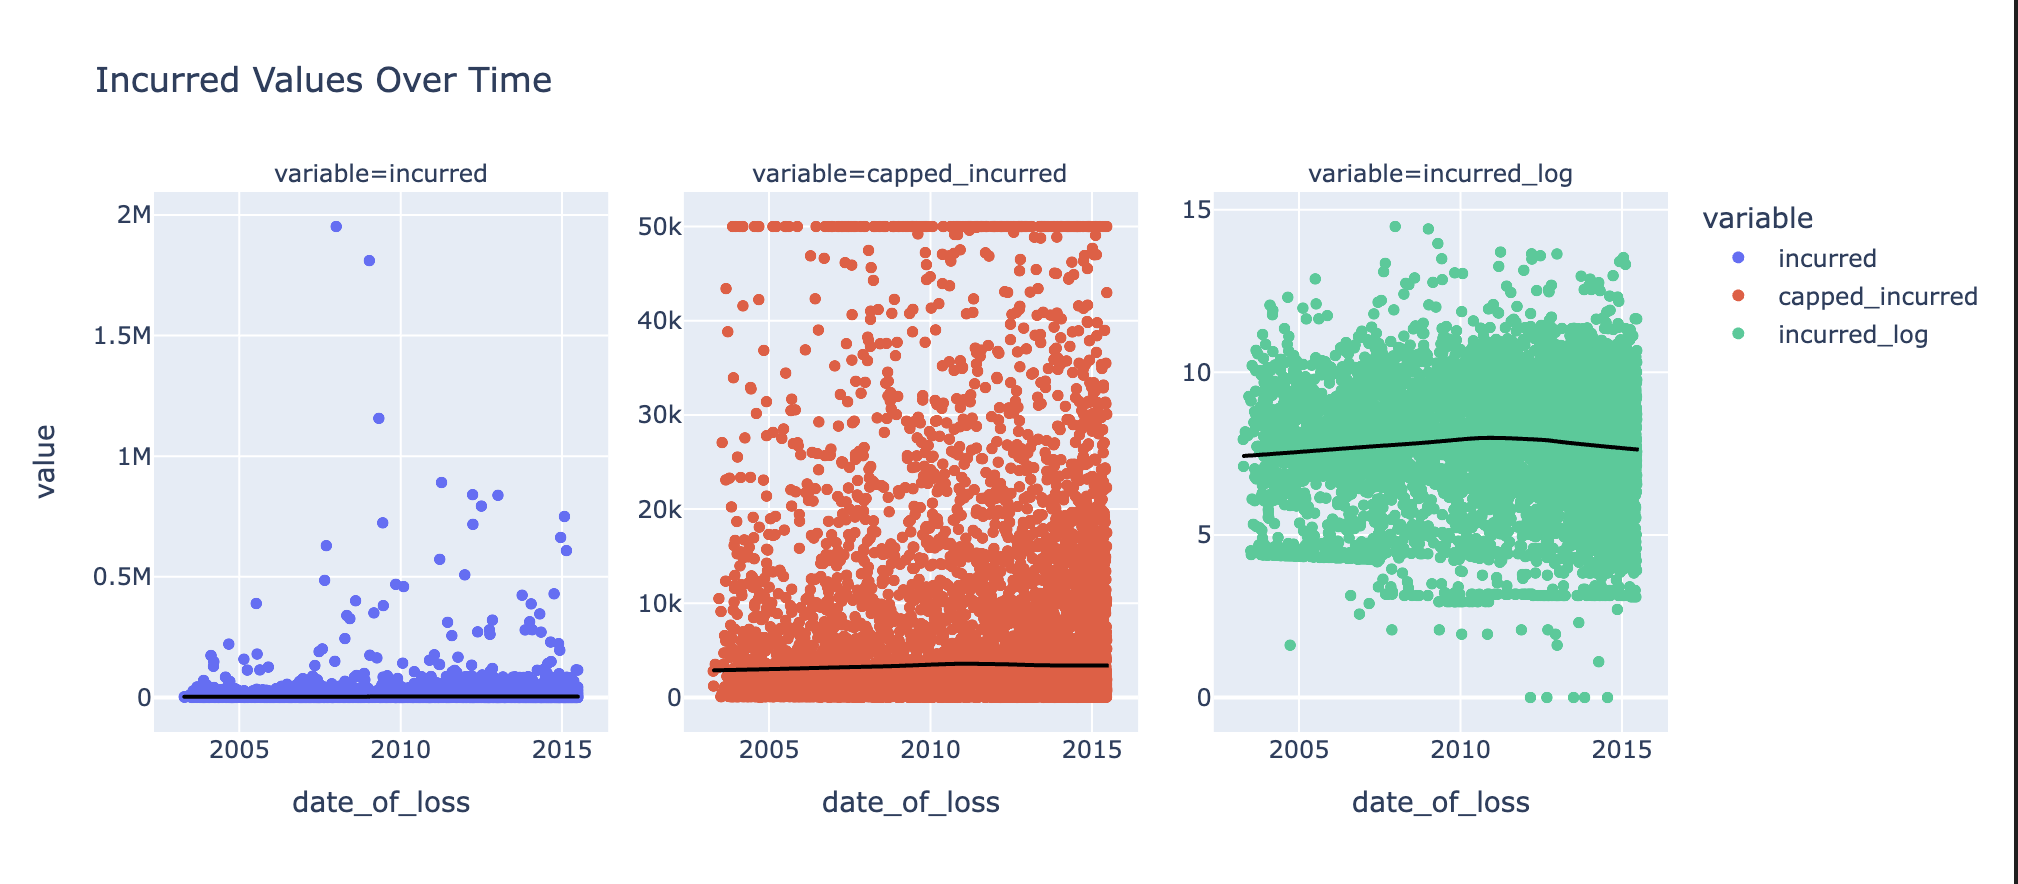

</div>

# Feature Engineering

* Time series decomposition showed some cyclical trends

<div style="max-width:500px;margin-right: auto; margin-right: 0;">

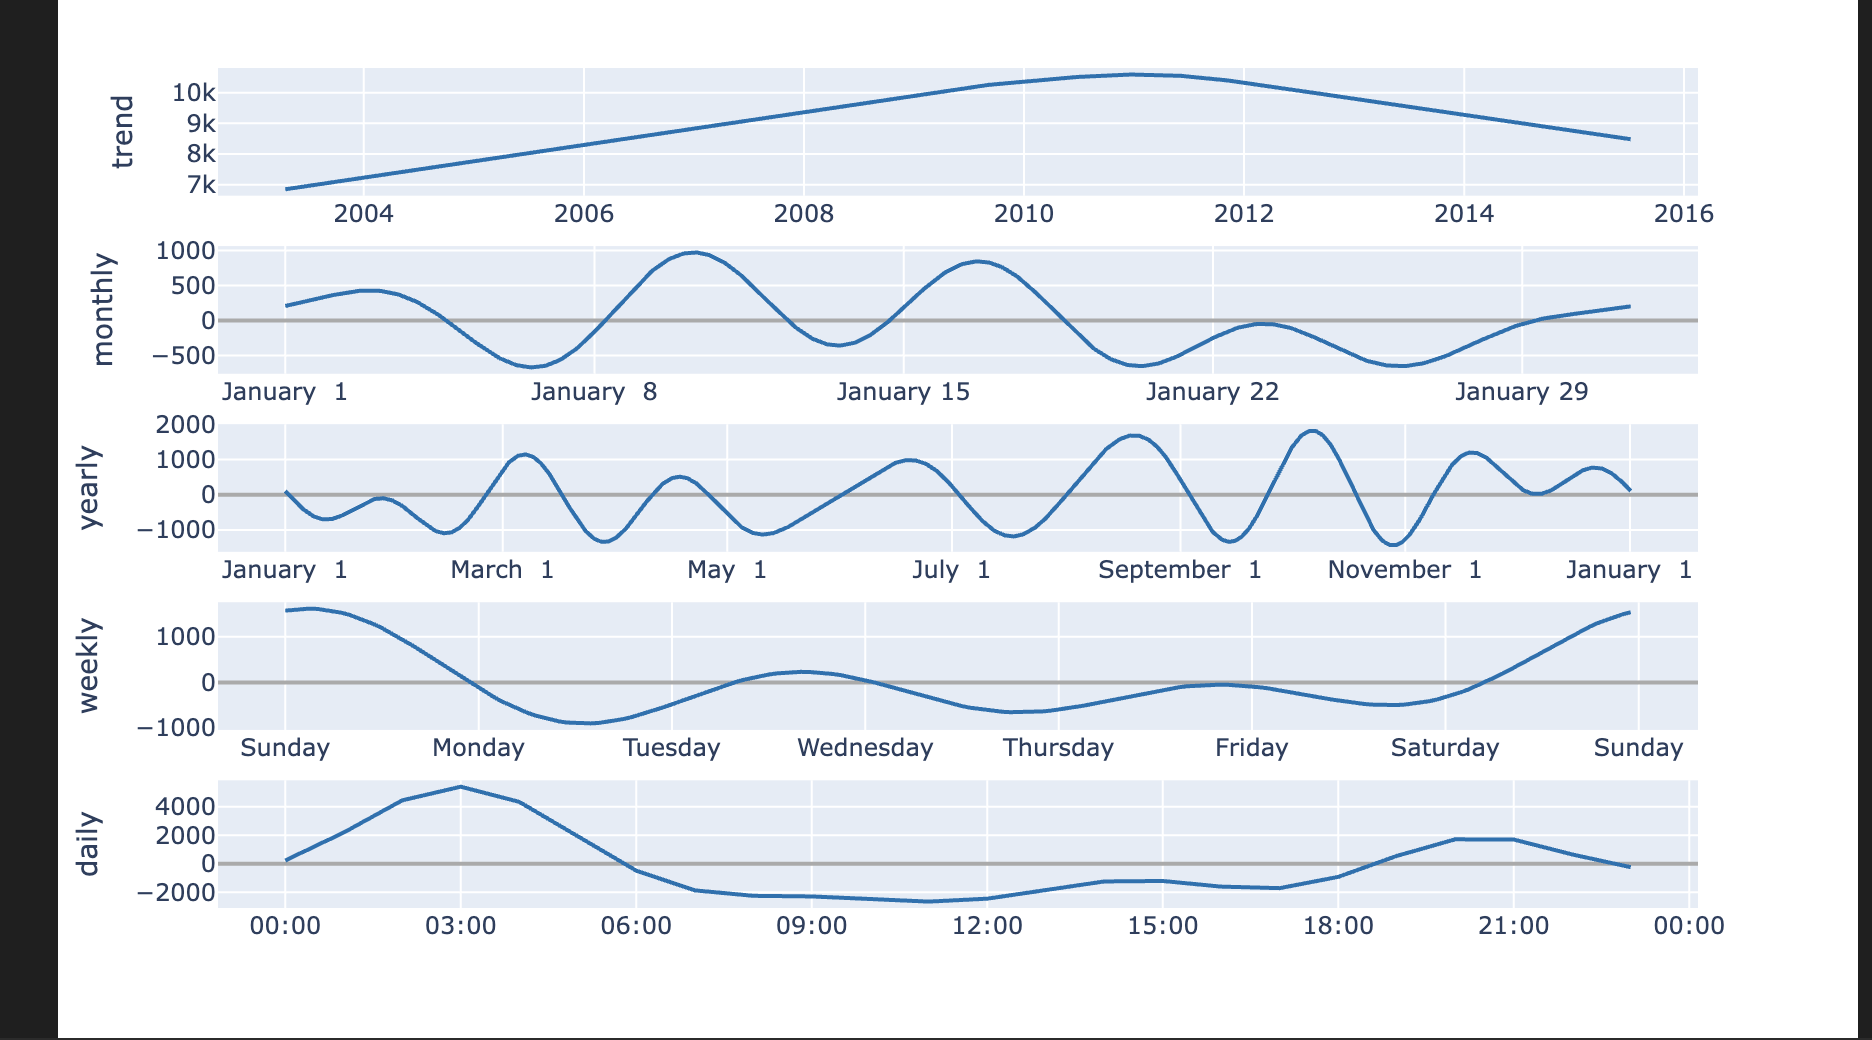

</div>

So I generated features that would allow models to capture cyclical element as well as buckets with indicator variables to allow the key part of the time/ date feature to be selected directly (e.g nighttime, commute hour, weekend)

<div style="max-width:500px;margin-right: auto; margin-right: 0;">

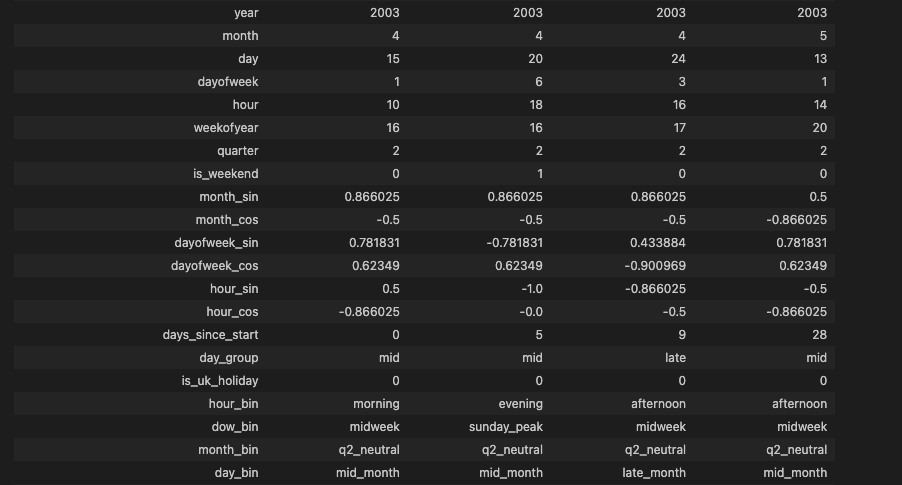

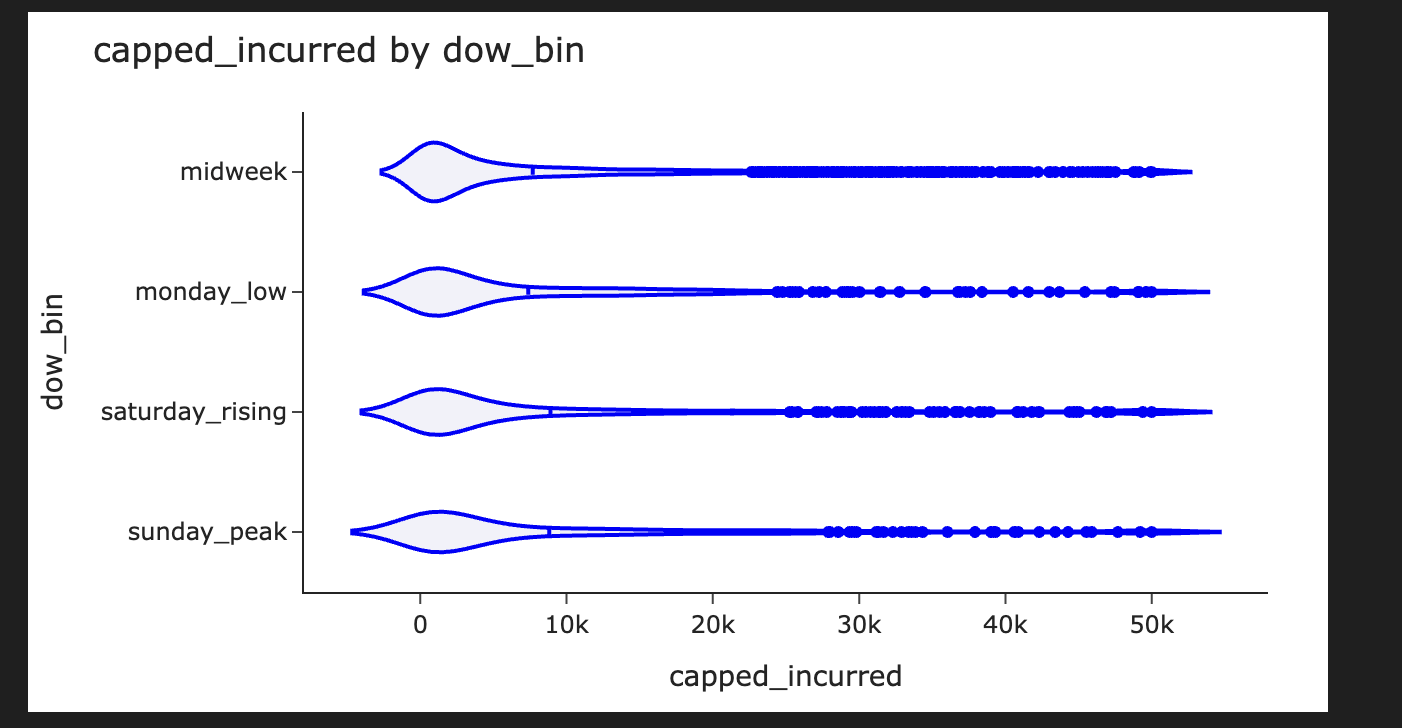

</div>

* As there were number of categorical features, some of which had high cardinality I built a couple of functions to explore the relationship to target as well as coverage over time

<div style="max-width:600px;margin-right: auto; margin-right: 0;">

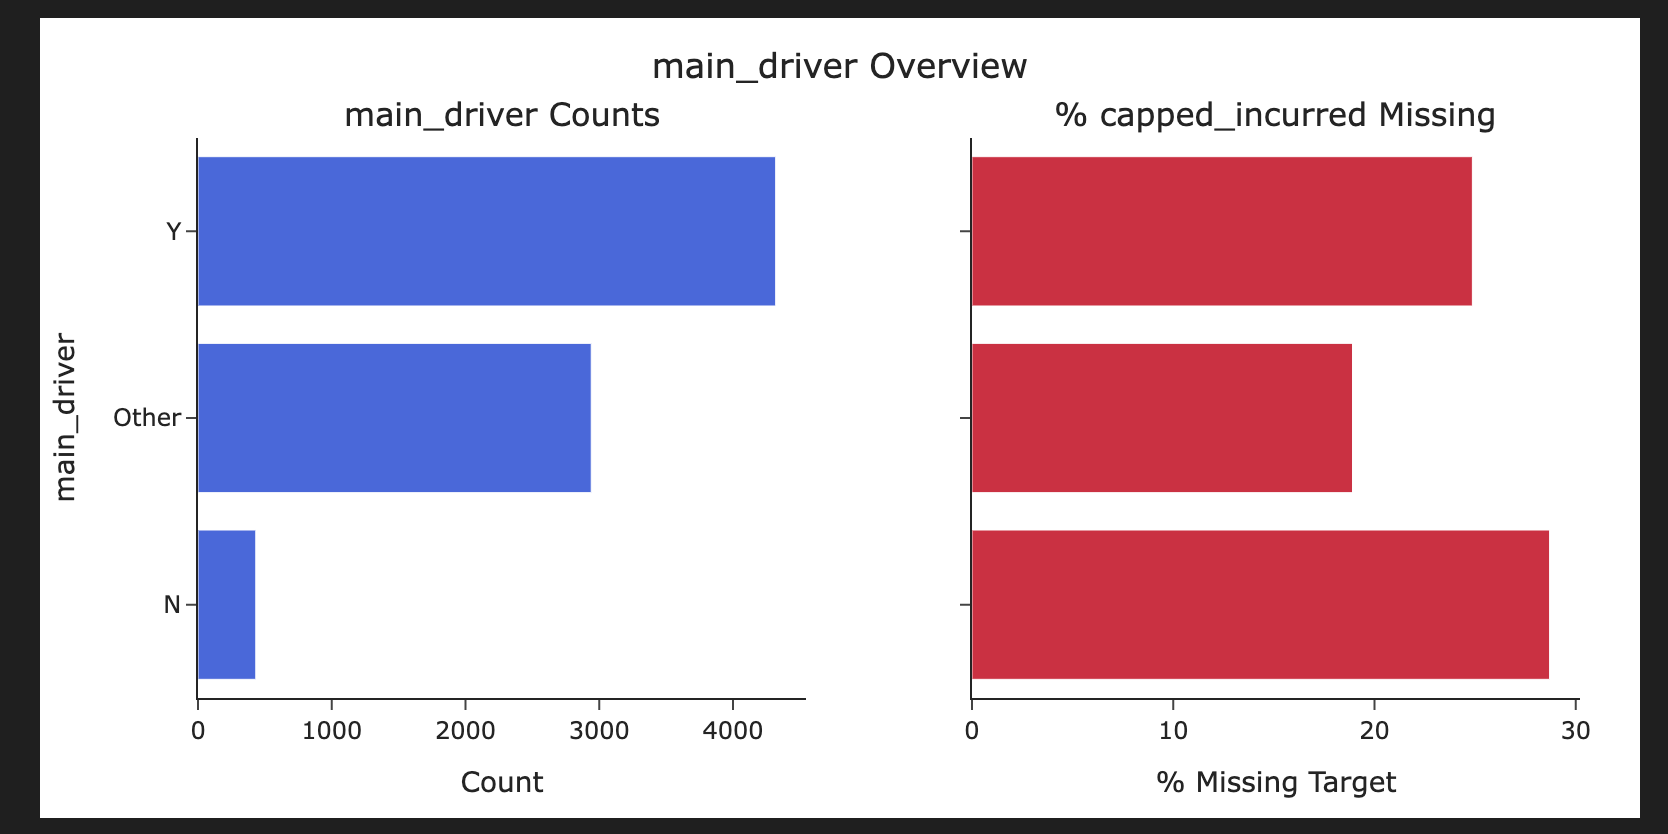

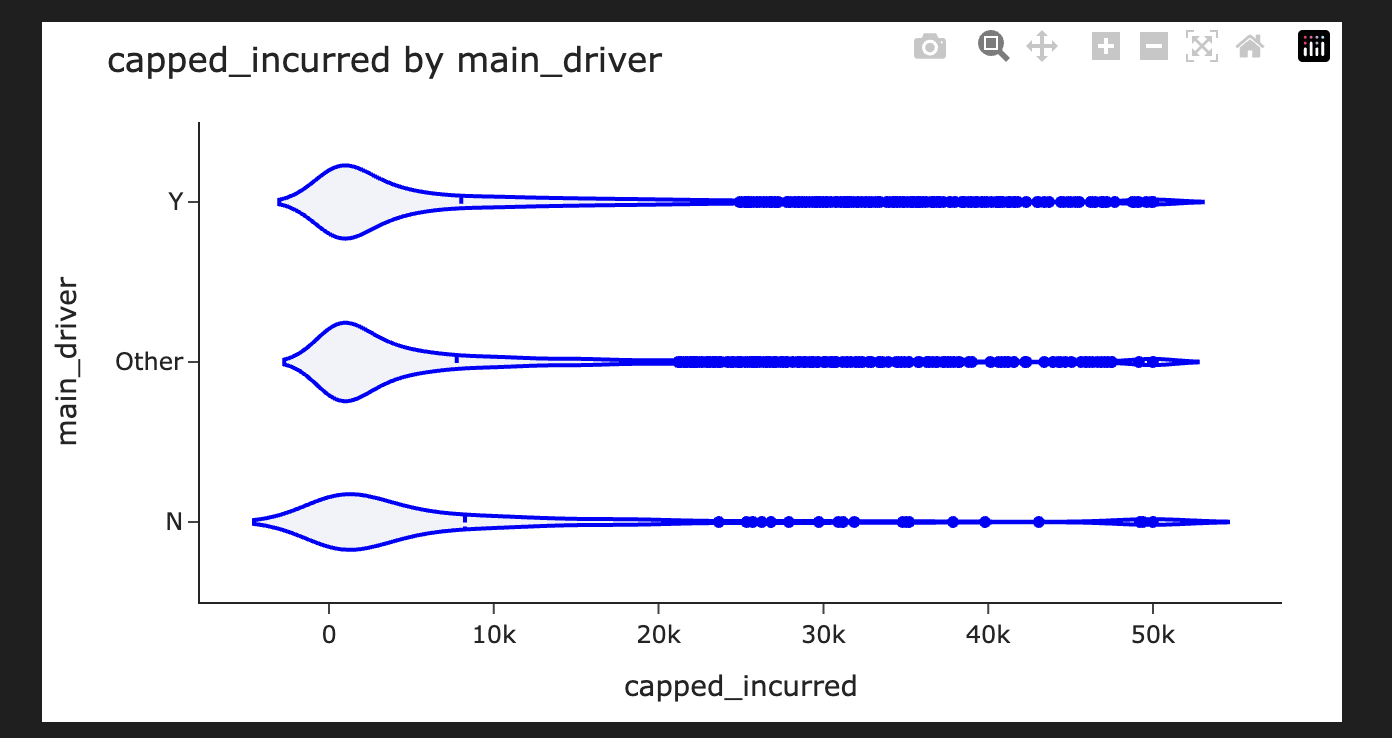

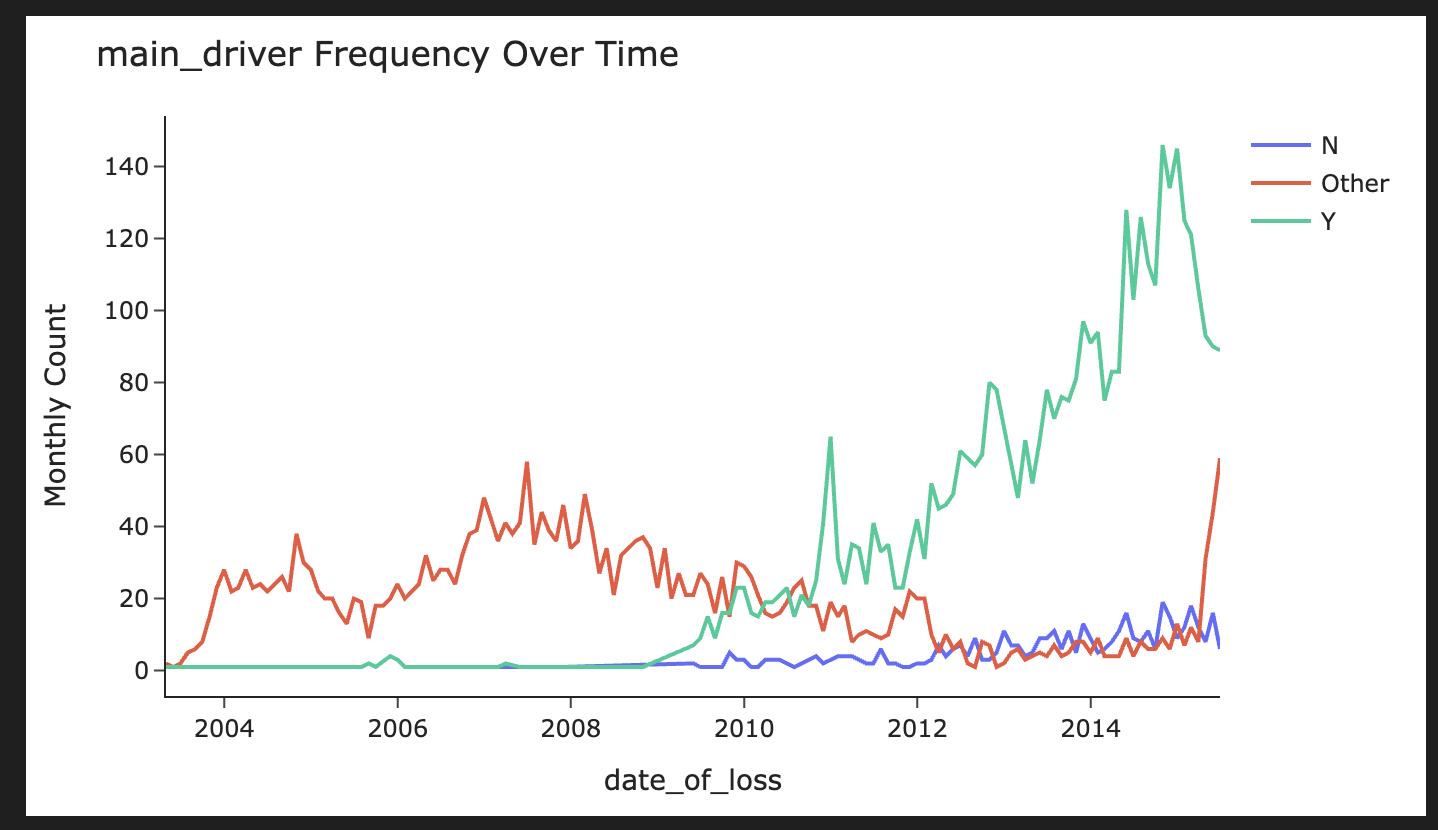

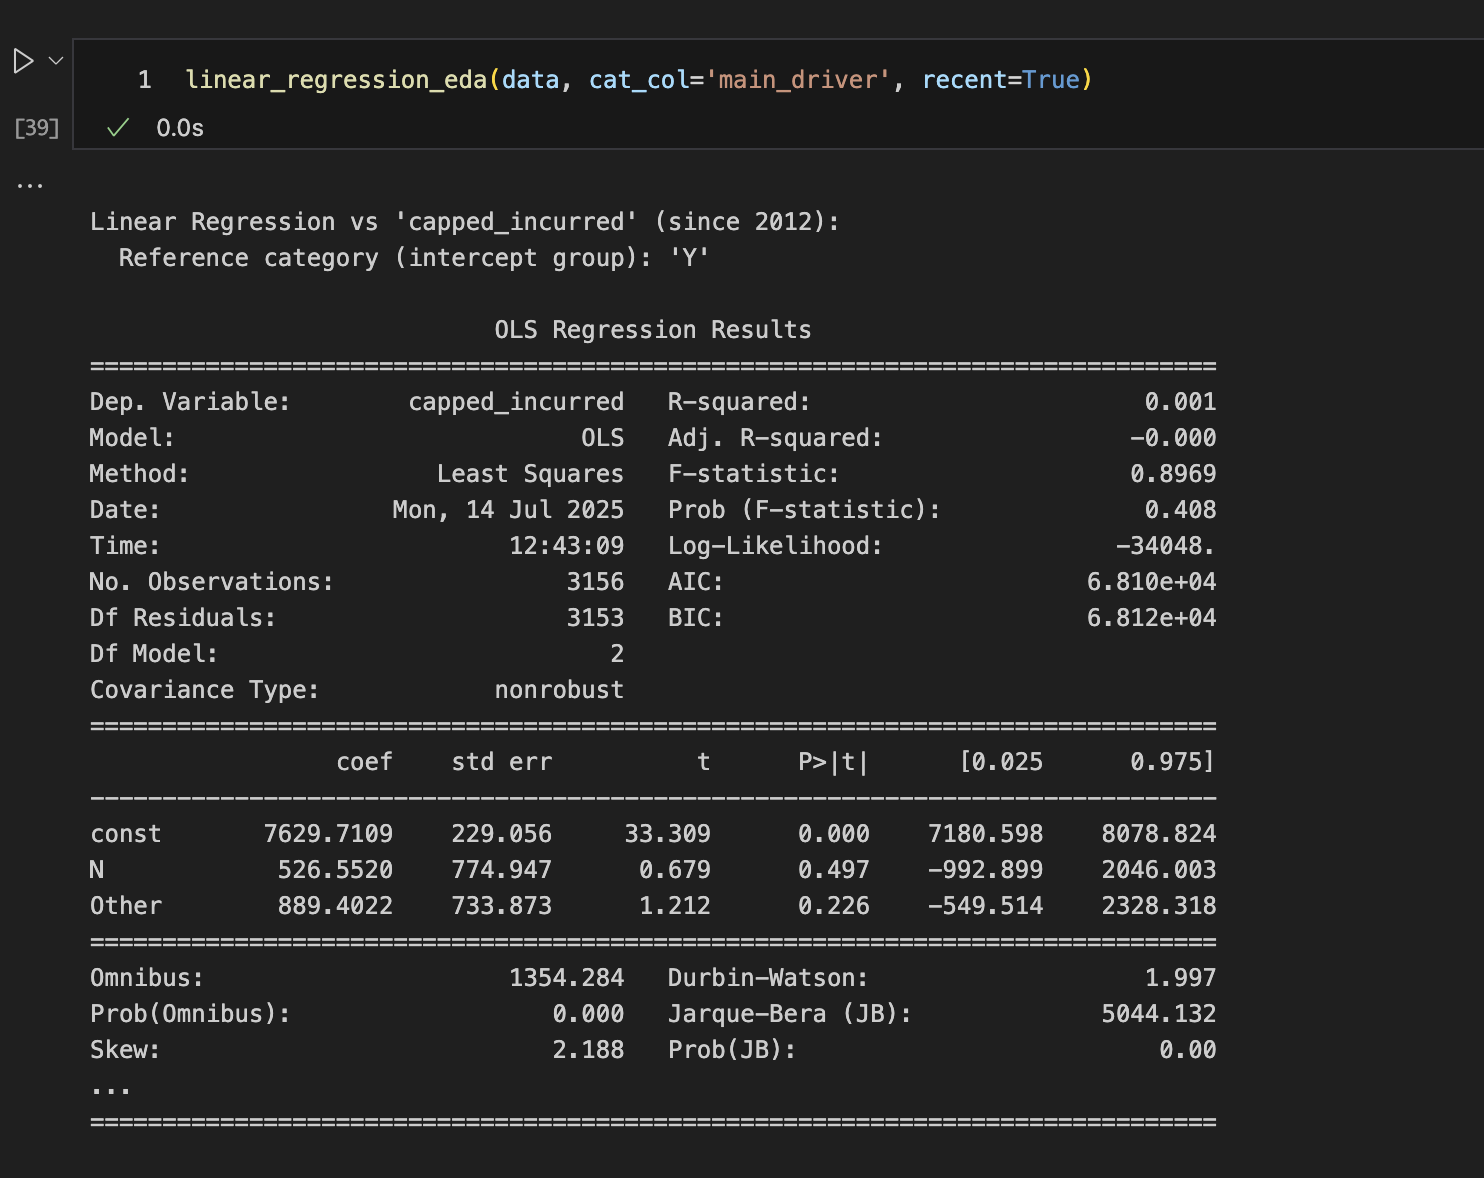

</div>


Running the Linear Regression vs target allowed me to capture an r2 value to be used in feature selection later



### Categorical Encoding

* For Categorical Variables I made encoding functions that produce dummy variables as well as mean target encoding.
* The key part of this was to derive the mean for each category from the train set and then apply as a transform to the train and test set. 
* This prevents target leakage in the test set 

<div style="max-width:600px;margin-right: auto; margin-right: 0;">

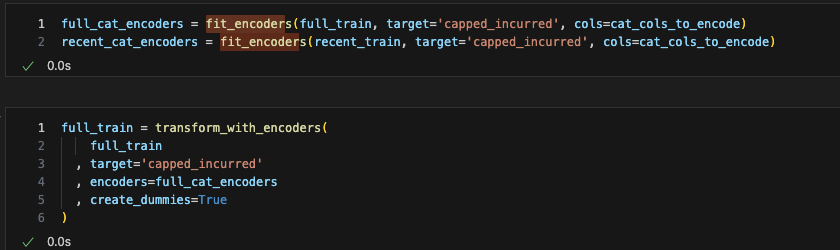

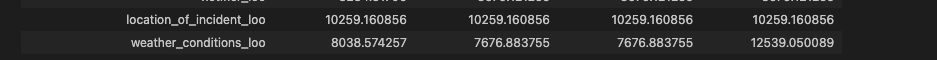

Note the columns are suffixed 'loo' for Leave One Out but this wasnt the final implementation

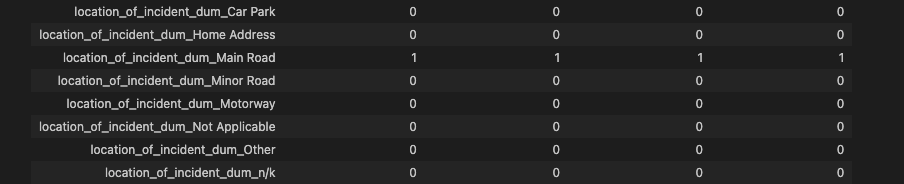

</div>

### Grouped Count Variables

* Since there were lots of grouped count variables that model specs might not understand the relatiobship between I also adding mean target encoding to summarise

<div style="max-width:300px;margin-right: auto; margin-right: 0;">

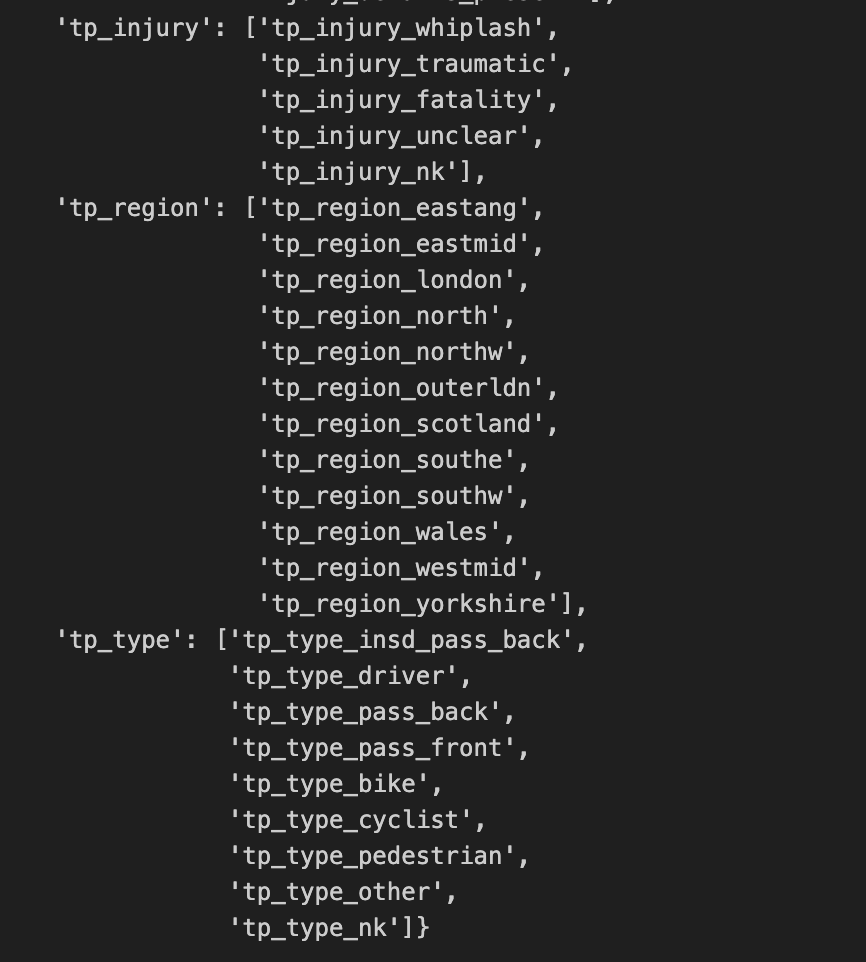

</div>

<div style="max-width:600px;margin-right: auto; margin-right: 0;">

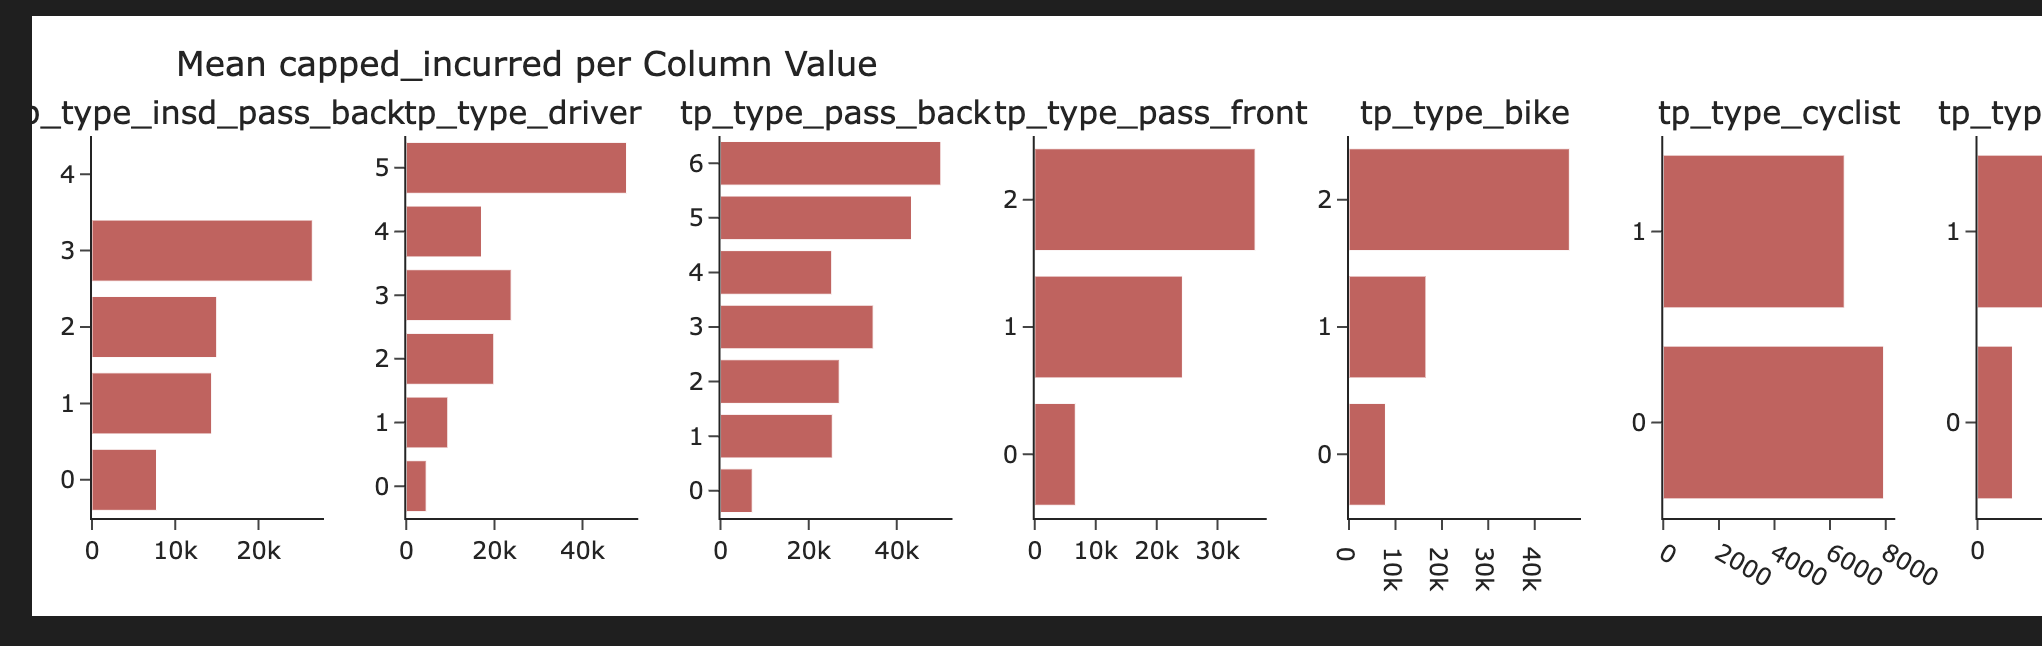

</div>

I generated both mean target encoded values for the individual count colunns and then also summed them to find a single total for the group as a whole if I wanted to incorporate the signal from the feature group without the excessive dimensionality

<div style="max-width:700px;margin-right: auto; margin-right: 0;">

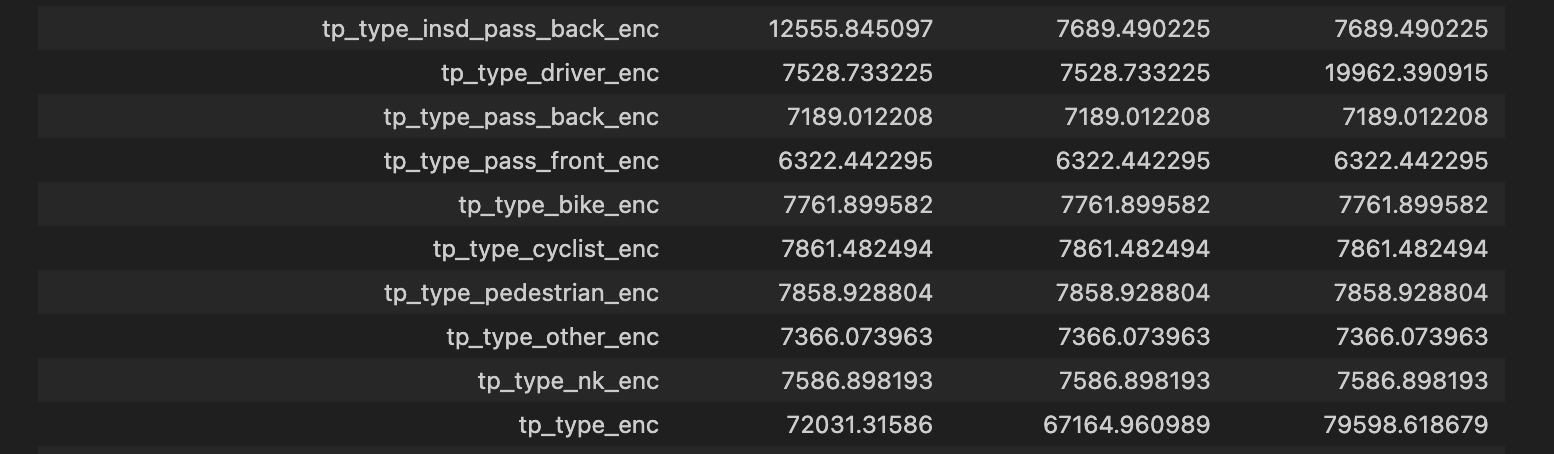

</div>



### Interaction Terms

* Despite using some modelling algorithms that can handle interactions themselves I wanted to boost the chance of finding meaningful relationships so I created some logical features manually

<div style="max-width:600px;margin-right: auto; margin-right: 0;">

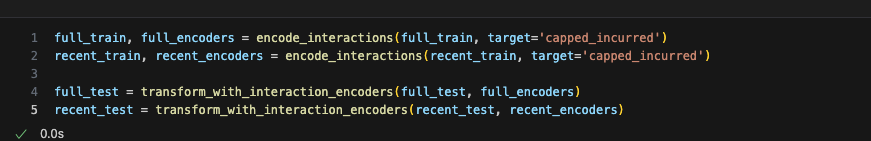

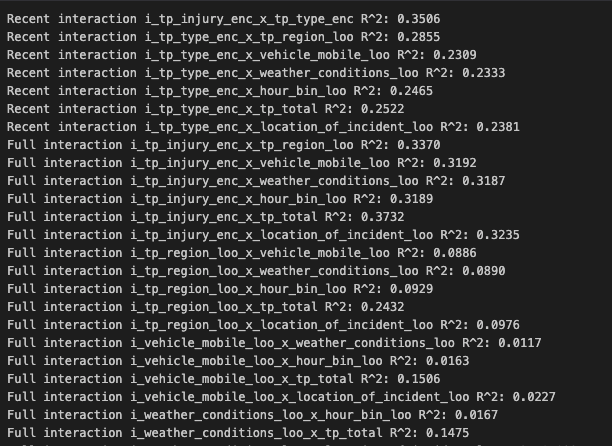

</div>

* For simplicity and to avoid having to deal with lots of different data types I built interactions by splitting the already mean target encoded summary variables into bins and then create combinations of bins between the two source columns. Then I found the new target mean and applied that as an encoder (again only fitting on train sets and transform on test sets)
* More work could be done here to explore dummy variable creating and interactions between specific count columns and other columns rather than the group of count column encoded summary


# Modelling Choices

## Target Choice
* Approached as a continous prediction problem. 
* Considered combining with high value binary flag and using different models to predict given whether its a high value predicted case or not but that would be a future improvement
* Tested modelling capped_incurred, incurred, capped_incurred_log and incurred_log. The best R2 was found on capped_incurred so stuck with this
* We could easily draw bands within this to make prediction into a binary or categorical outcome

## Test Train Split
* Test train split done on date rather than random sampling to better assess chance to generalise to the future
* Produced two test train splits based on data availability

<div style="max-width:800px;margin-right: auto; margin-right: 0;">

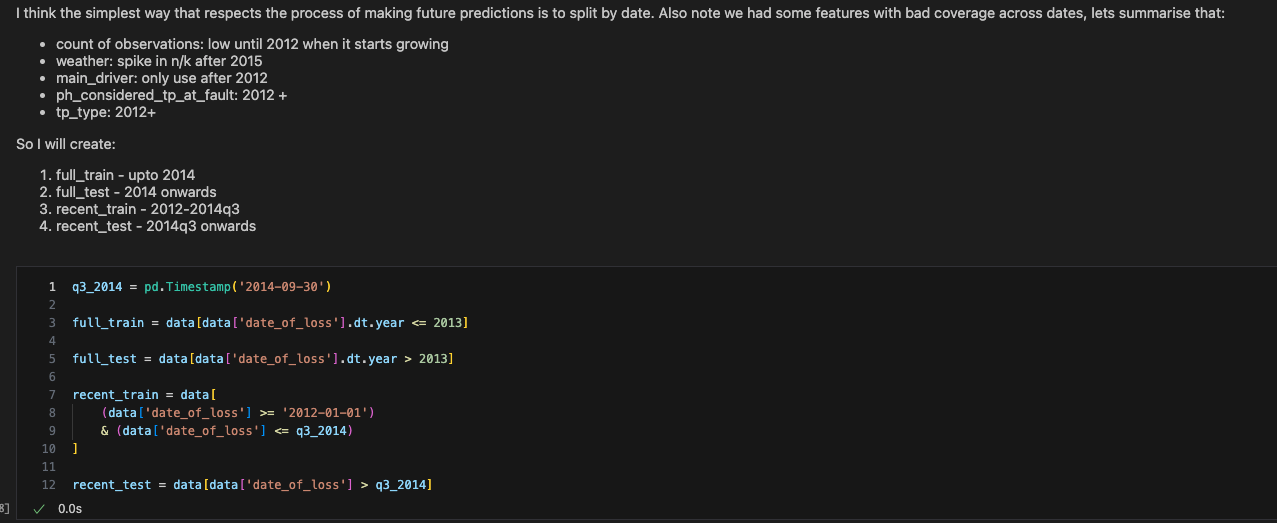

</div>

## Quick Model Evaluation
* I built helper functions to automate the evaluation and diagnose problems

<div style="max-width:400px;margin-right: auto; margin-right: 0;">

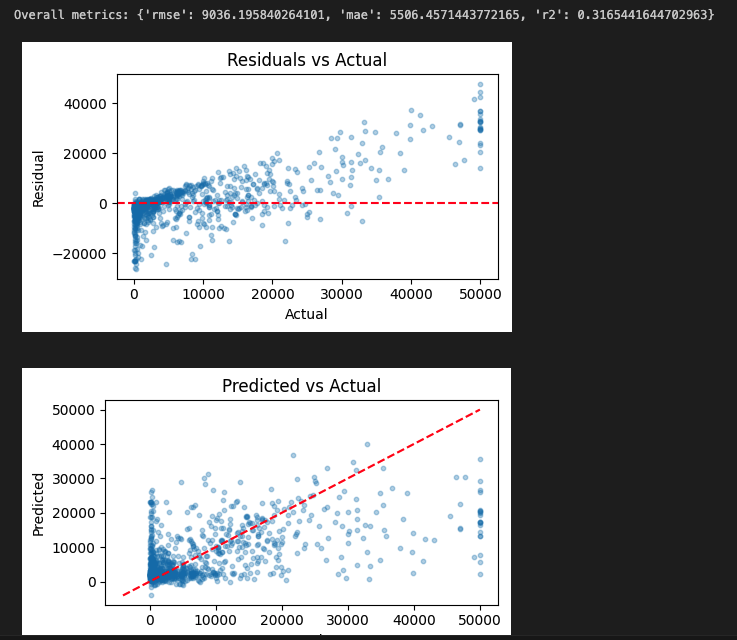

</div>

## Algorithm Choice

* I tried the following modelling approaches: Random Forest, Linear Regression (least squares), Gradient Boosting Machine, Linear Regression with Stepwise Feature selection


### Random Forest

Notebooks 02 and 06 (with standardisation)

* Chosen for its ability to capture non-linear effects and interactions without needing the data to be normalized or transformed
* Performs pretty well with colinear features and can act as a feature selection process
* Whilst it cant well capture long term growth to the extent we would need to predict outside of the training data range we didnt observed this in the time series decomposition so it was a robust choice
* Tried vs all 4 targets since it can handle skew in both predictors and target. Preferred results against capped_incurred
* Initially planned to use this to mine feature importance to feed into linear model for greater interpretability
* Chose fairly deep parameters to maximise interaction mining capabilities
* Tried hyper-parameter tuning but it didnt help much

<div style="max-width:400px;margin-right: auto; margin-right: 0;">

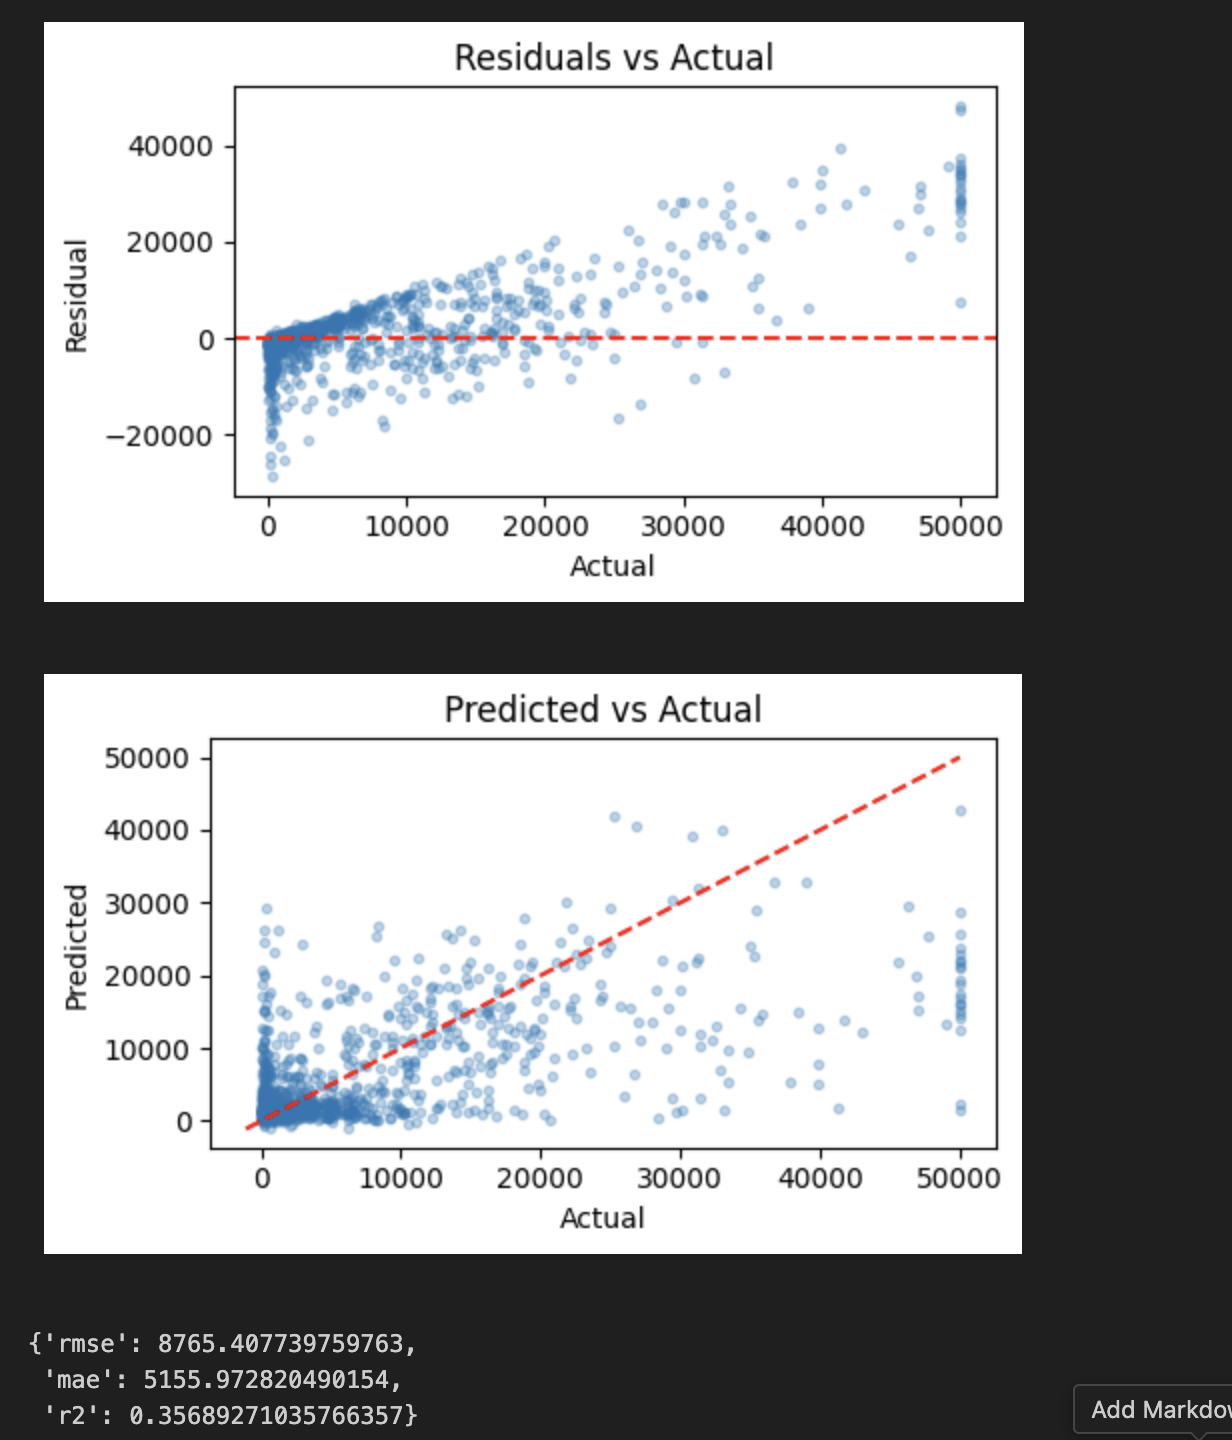

</div>

* The best RF model achieved r2 of 0.356 on eval set using the Recent Data Features and choosing MAE rather than RMSE as loss metric. This loss choice may have helped due to attaching more importance to the lower value actuals vs RMSE which is more sensitive to outliers
* Notice a fairly narrow range of prediction compared to actuals. This is due to the weakeness of taking the average of subsets of the target in the training set. The residual pattern makes some sense since we wont predict negative values but the clumping in the middle might mean additional improvements needed to predict high cost claims in particular

### Linear Regression

Notebooks 03, 04 (with scaling), 05 (with interactions), 08 (with stepwise feature selection)

* Chosen for its interpretability given a sensible specification
* However as a causal model has not been theorised yet with cofounding variables and interactions drawn out I would say the interpretability is limited as we do not want to fall victim to Table 2 fallacy
* Selecting variables manually gave the best results - I chose recent data only to allow full feature coverage. Preferred mean target encoded summary features for Third Party columns rather than the raw counts to reduce dimensionality. 
* Chose cos and sin features for hour to allow true cyclical relationship to be found but mean target encoded features for weather, DOW bucket and location of incident to reduce dimensionality

<div style="max-width:400px;margin-right: auto; margin-right: 0;">

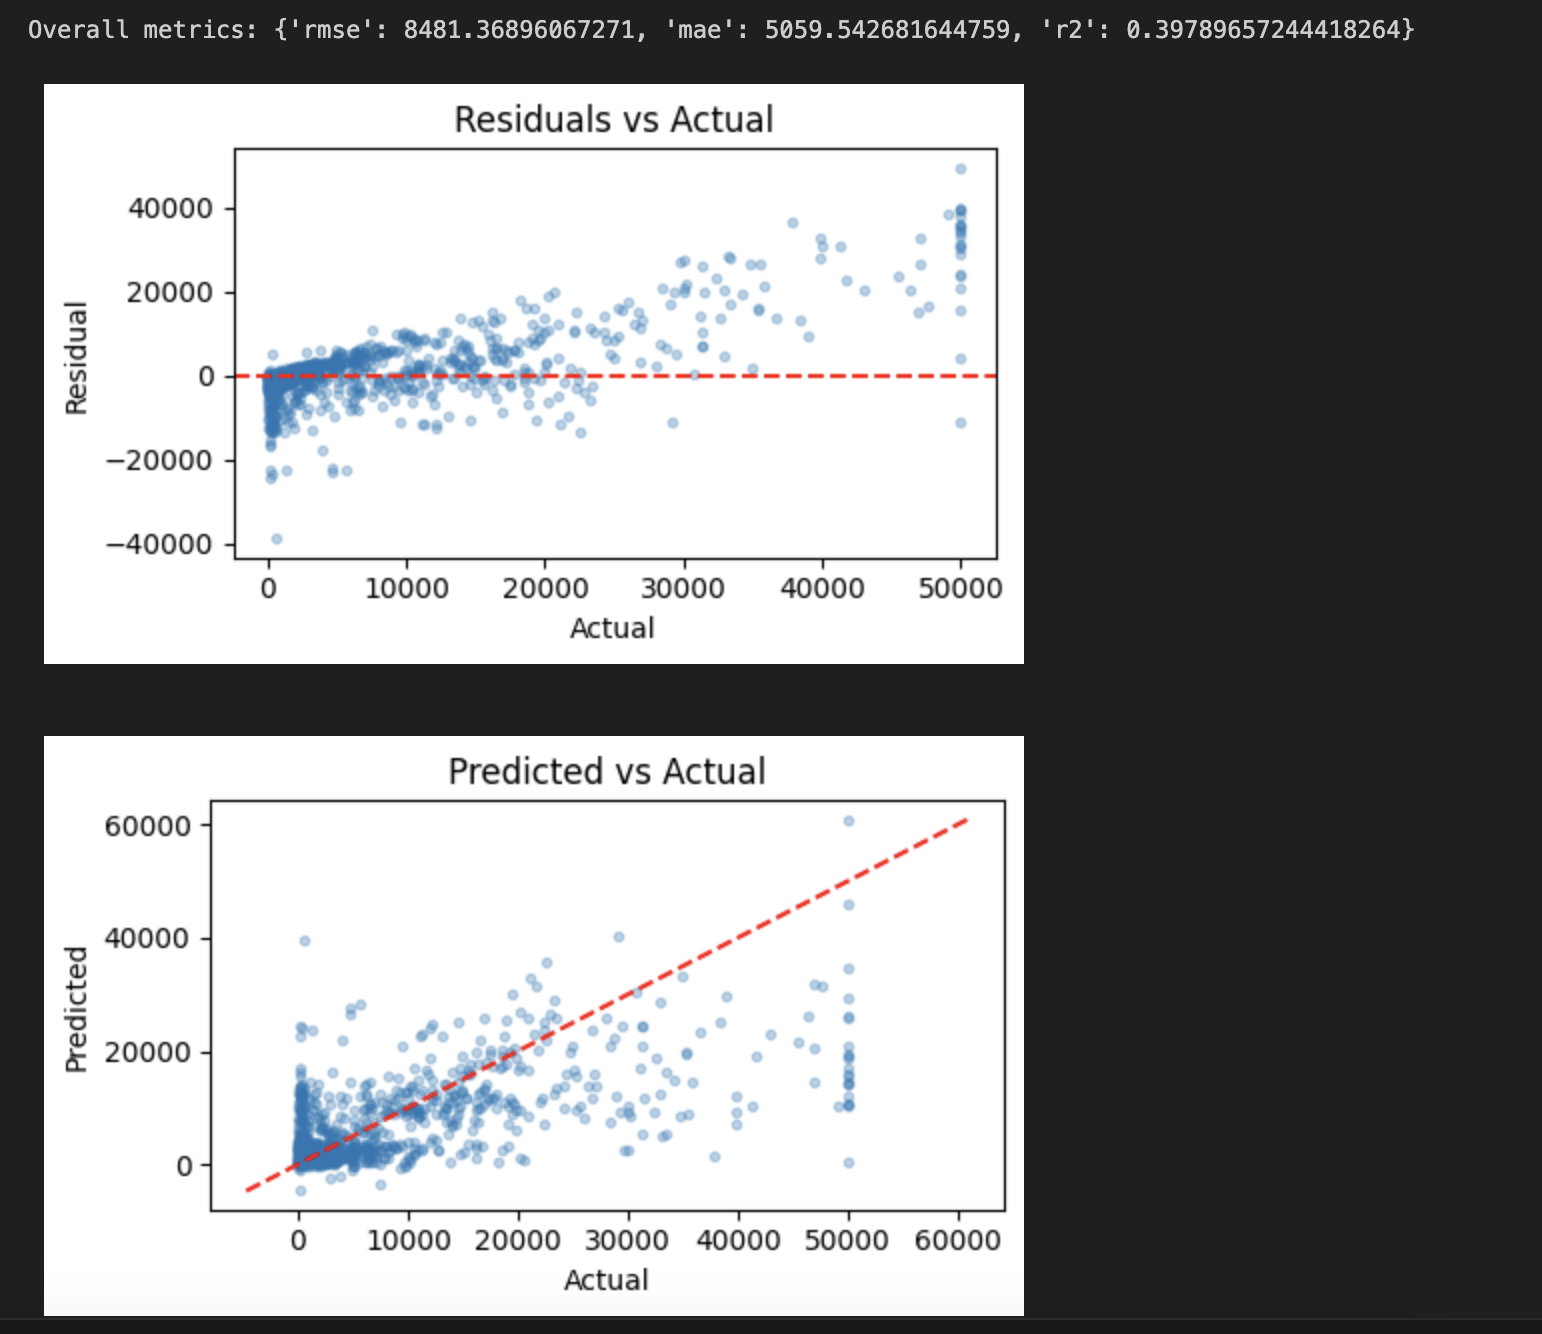

</div>

* The best RF model achieved r2 of 0.39 on eval set, which was nearly as good as our best performing model. The scaled model did slightly better but basically the same and had a slightly narrower range of predictions
* The narrowness of the prediction range was a bit better on the linear regression due to its ability to extend beyond seen target data
* Adding interaction terms made it notably worse and reducing the feature set with stepwise regression didnt help at all either vs manual feature selection

### Linear Regression

Notebooks 03, 04 (with scaling), 05 (with interactions), 08 (with stepwise feature selection)

* Chosen for its interpretability given a sensible specification
* However as a causal model has not been theorised yet with cofounding variables and interactions drawn out I would say the interpretability is limited as we do not want to fall victim to Table 2 fallacy
* Selecting variables manually gave the best results - I chose recent data only to allow full feature coverage. Preferred mean target encoded summary features for Third Party columns rather than the raw counts to reduce dimensionality. 
* Chose cos and sin features for hour to allow true cyclical relationship to be found but mean target encoded features for weather, DOW bucket and location of incident to reduce dimensionality

<div style="max-width:400px;margin-right: auto; margin-right: 0;">

![image.png](attachment:image.png)

</div>

* The best RF model achieved r2 of 0.39 on eval set, which was nearly as good as our best performing model. The scaled model did slightly better but basically the same and had a slightly narrower range of predictions
* The narrowness of the prediction range was a bit better on the linear regression due to its ability to extend beyond seen target data
* Adding interaction terms made it notably worse and reducing the feature set with stepwise regression didnt help at all either vs manual feature selection

In [ ]:
# hastings

- Issues identified with the data and how these were addressed
- Data cleansing

* 



- Model specification and justification for selecting this model specification

* 
* 
* Considered predictive accuracy above robust coefficient estimation. So used some boosting and bagging (rf and gbm) approaches as well as multiple regression. 
* GBM handle non-linear relationships, skew in target and predictor distributions, mixed data types, high levels of colinearity
* Extensive use of mean target encoding for categorical and multivariable counts although also compared predictive value of counts and dummy variables as appropriate
* All features were run as predictors for a simple linear model vs target in EDA and I prioritised those that had a visible relationship to target or a statistically significant coefficient.
* Ensemble trees were used to find hidden interactions efficiently. Hyper-parameter tuning was attempted but had little improvement over the feature selection. 
* Manual interaction terms were created based on terms that plausibly might interact. I opted for meant
* Applied stepwise regression with manual coefficient colinearity filtering to mine features that were predictive but not overly correlated amongst themselves. Was not as effective as allowing gradient boosting access to more columns
* Used RF feature importance to select variables for linear regression but again wasnt as effective as experimenting manually

- Assessment of your model's accuracy and model diagnostics
* Found a decent level of signal but without a model that has robust coefficient interpretation
* Earlier models had awful residuals but later they looked healthier where error could only be in one direction at the lowest points
* Tree based models were overly focussed around the mid range of predictions. Multiple regression spread more nicely

- Suggestions of how your model could be improved
* Bayesian causal approach with DAG and interpretable coefficient
* Ensembling multiple models
* 2 stage prediction, first a binary high value flag then incurred within that subset
* More exploration of scaling and transforming features to be normally distributed
* Try dimensionality reduction of large feature set
* Add external data e.g. weather


- Practical challenges for implementing your model

* 